#### Zillow Clustering Analysis
**Artifact: Jupyter Notebook Report**

Created by: Mijail Q. Mariano

Presented: Tuesday, August 09th 2022

-----

**Required Libraries & Modules**

In [1]:
%matplotlib inline
import matplotlib as mlp
# mlp.rcParams['figure.dpi'] = 300

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# importing key libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

# numpy import
import numpy as np

# scipy import
import scipy.stats as stats
import math
from math import sqrt

# datetime module for home transaction dates
import datetime

# importing acquire module
import acquire
from acquire import get_zillow_dataset, \
                    clean_zillow_dataset, \
                    age_of_homes, \
                    get_lower_and_upper_bounds, \
                    zillow_outliers, \
                    clean_months, \
                    null_df, \
                    train_iterative_imputer, \
                    impute_val_and_test, \
                    train_validate_test_split, \
                    get_transaction_quarters, \
                    get_dummy_dataframes, \
                    get_cluster_dummy

# importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style = "darkgrid")

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import RFECV

----
### **``Project Scope and Objectives:``**

<u>``Scope:``</u> Apply machine learning clustering techniques to better segment Zillow's real-estate data and reduce the overall error in predicted home evaluations as measured by Zillow's "Zestimate". 

<u>``Objectives:``</u>

1. Acquire and clean the Zillow dataset
2. Apply and treat outliers in the dataset (make recommendations)
3. Identify and treat missing values in the dataset
4. Generate statistical hypotheses for testing
5. Use dataset features to create clusters
6. Generate visualizations to interpret clusters and make selections for modeling
7. Use clusters to model logerror predictions and evaluate results
8. Make final recommendations



-----

### **``Data Acquisition and Preparation``**

**``Key Highlights``**

- Used domain knowledge and research to focus on key questions for analysis
- Renamed and converted columns/features to proper data type
- Dropped initial records and features with > 80% Null values
- Added columns:
    - "Home Age"
    - "Transactions by Month"
    - "Transactions by Quarter"





*these homes represented homes larger than the majority homes in the dataset, therefore making the analysis or future prediction less accurate or obscured when including these records in the analysis.* *

In [2]:
# acquiring and preparing initial zillow dataset

df = get_zillow_dataset()
df = clean_zillow_dataset(df)
df = age_of_homes(df)

df.head()

dataframe shape: (52238, 15)


,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,transaction_date,year_built,home_age
0,14297519,1023282.00,0.03,3.50,4.00,3100.00,Orange County,33634931.00,-117869207.00,4506.00,122,60590630.072012,2017-01-01,1998.00,19.00
1,17052889,464000.00,0.06,1.00,2.00,1465.00,Ventura County,34449266.00,-119281531.00,12647.00,1110,61110010.02300601,2017-01-01,1967.00,50.00
2,14186244,564778.00,0.01,2.00,3.00,1243.00,Orange County,33886168.00,-117823170.00,8432.00,122,60590218.022012,2017-01-01,1962.00,55.00
3,12177905,145143.00,-0.10,3.00,4.00,2376.00,LA County,34245180.00,-118240722.00,13038.00,0101,60373001.00100601,2017-01-01,1970.00,47.00
4,12095076,773303.00,-0.00,3.00,4.00,2962.00,LA County,34145202.00,-118179824.00,63000.00,0101,60374608.001014,2017-01-01,1950.00,67.00


----
```Dataset Summary Statistics:```

In [3]:
# dataframe info:

sorted_cols = df.columns.sort_values()
df[sorted_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52238 entries, 0 to 52318
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   bathroom_count         52238 non-null  float64       
 1   bedroom_count          52238 non-null  float64       
 2   blockgroup_assignment  52238 non-null  object        
 3   county_by_fips         52238 non-null  object        
 4   county_zoning_code     52238 non-null  object        
 5   home_age               52200 non-null  float64       
 6   home_value             52237 non-null  float64       
 7   latitude               52238 non-null  float64       
 8   living_sq_feet         52238 non-null  float64       
 9   logerror               52238 non-null  float64       
 10  longitude              52238 non-null  float64       
 11  parcel_id              52238 non-null  object        
 12  property_sq_feet       51881 non-null  float64       
 13  t

In [4]:
# dataframe summary statistics:

summary_stats = df.describe().T
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats.sort_index()

,count,mean,std,min,25%,50%,75%,max,range
bathroom_count,52238.00,2.30,1.02,0.00,2.00,2.00,3.00,18.00,18.00
bedroom_count,52238.00,3.31,0.94,0.00,3.00,3.00,4.00,14.00,14.00
home_age,52200.00,53.58,23.13,1.00,38.00,56.00,67.00,139.00,138.00
home_value,52237.00,528254.91,748552.14,1000.00,193975.00,373624.00,618938.00,49061236.00,49060236.00
latitude,52238.00,34022828.63,273962.14,33340620.00,33827154.75,34024016.50,34187392.00,34818767.00,1478147.00
living_sq_feet,52238.00,1923.17,1004.05,128.00,1268.00,1659.00,2306.00,21929.00,21801.00
logerror,52238.00,0.02,0.18,-4.66,-0.02,0.01,0.04,5.26,9.92
longitude,52238.00,-118194252.01,356454.13,-119475416.00,-118400911.00,-118153275.50,-117929615.00,-117554636.00,1920780.00
property_sq_feet,51881.00,11243.16,86603.92,236.00,5581.00,6840.00,8785.00,6971010.00,6970774.00
year_built,52200.00,1963.42,23.13,1878.00,1950.00,1961.00,1979.00,2016.00,138.00


-----
```Handling Outliers:```

In [5]:
# using "iqr" method to determine lower and upper bounds for continuous variables

get_lower_and_upper_bounds(df)

dataframe shape: (8, 7)


,column,column type,iqr,lower_bound,lower_outliers,upper_bound,upper_outliers
0,home_value,float64,424963.00,-443469.50,0,1256382.50,3507
1,logerror,float64,0.07,-0.12,2625,0.14,3769
2,bathroom_count,float64,1.00,0.50,46,4.50,1577
3,bedroom_count,float64,1.00,1.50,670,5.50,777
4,living_sq_feet,float64,1038.00,-289.00,0,3863.00,2272
5,property_sq_feet,float64,3204.00,775.00,42,13591.00,5528
6,year_built,float64,29.00,1906.50,240,2022.50,0
7,home_age,float64,29.00,-5.50,0,110.50,240


In [6]:
# cleaning dataset for outliers at lower and upper bounds

df = zillow_outliers(df)

dataframe shape: (38534, 15)


#### <u>**Note on Outliers:**</u>


----

In [7]:
# adding transactions by month column

df = clean_months(df)
df.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,home_age,transaction_month
0,14297519,1023282.00,0.03,3.50,4.00,3100.00,Orange County,33634931.00,-117869207.00,4506.00,122,60590630.072012,1998.00,19.00,January
1,17052889,464000.00,0.06,1.00,2.00,1465.00,Ventura County,34449266.00,-119281531.00,12647.00,1110,61110010.02300601,1967.00,50.00,January
2,14186244,564778.00,0.01,2.00,3.00,1243.00,Orange County,33886168.00,-117823170.00,8432.00,122,60590218.022012,1962.00,55.00,January
3,12177905,145143.00,-0.10,3.00,4.00,2376.00,LA County,34245180.00,-118240722.00,13038.00,0101,60373001.00100601,1970.00,47.00,January
5,12069064,218552.00,0.10,1.00,2.00,738.00,LA County,34149214.00,-118239357.00,4214.00,0100,60373020.041001,1922.00,95.00,January


----
#### **``Splitting the Zillow Dataset for Hypothesis Testing:``**

Highlights:

- initial dataset: (52238, 14)
- dataset after cleaning: (38293, 15)

In [8]:
# splitting the Zillow dataset

train, validate, test = train_validate_test_split(df)

train shape: (21578, 15)
validate shape: (9249, 15)
test shape: (7707, 15)


In [9]:
# detecting and handling missing values in the training dataset

null_df = null_df(train)
null_df

,Total Null,Feature Null %
property_sq_feet,131,0.01
year_built,6,0.00
home_age,6,0.00
home_value,1,0.00
parcel_id,0,0.00
logerror,0,0.00
bathroom_count,0,0.00
bedroom_count,0,0.00
living_sq_feet,0,0.00
county_by_fips,0,0.00


In [10]:
# handling remaining null values using sklearn's iterative imputer

train_imputed = train_iterative_imputer(train)
train_imputed.isnull().sum() # checks out!

parcel_id                0
home_value               0
logerror                 0
bathroom_count           0
bedroom_count            0
living_sq_feet           0
county_by_fips           0
latitude                 0
longitude                0
property_sq_feet         0
county_zoning_code       0
blockgroup_assignment    0
year_built               0
home_age                 0
transaction_month        0
dtype: int64

In [11]:
# handling validate and test datasets

validate_imputed, test_imputed = impute_val_and_test(train, validate, test)

null results in: validate
----------------------------|---------
parcel_id                0
home_value               0
logerror                 0
bathroom_count           0
bedroom_count            0
living_sq_feet           0
county_by_fips           0
latitude                 0
longitude                0
property_sq_feet         0
county_zoning_code       0
blockgroup_assignment    0
year_built               0
home_age                 0
transaction_month        0
dtype: int64

null results in: test
----------------------------|---------
parcel_id                0
home_value               0
logerror                 0
bathroom_count           0
bedroom_count            0
living_sq_feet           0
county_by_fips           0
latitude                 0
longitude                0
property_sq_feet         0
county_zoning_code       0
blockgroup_assignment    0
year_built               0
home_age                 0
transaction_month        0
dtype: int64


-----
### <u>``Analyzing the Target Variable (logerror)``</u>

*logerror = log(Predicted: Zestimate) − log(Actual: Home Transaction Price)*

In [12]:
# setting alpha for hypothesis tests

alpha = 0.05

<Figure size 1440x216 with 0 Axes>

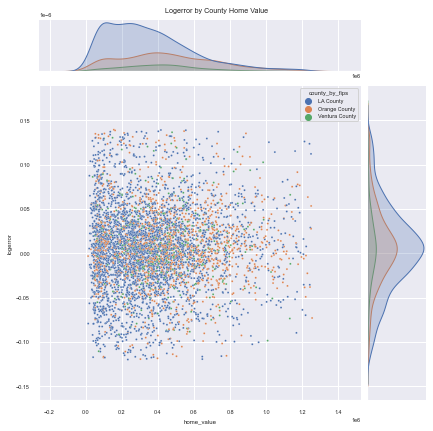

In [13]:
# examining logerror by county and home value

plt.figure(figsize = (20, 3))
sns.set(font_scale = .5)

p = sns.jointplot(
    data = train_imputed.sample(5000, random_state = 14),
    x = "home_value", 
    y = "logerror", 
    hue = "county_by_fips",
    s = 4)

p.fig.suptitle("Logerror by County Home Value")
p.fig.tight_layout()
p.fig.subplots_adjust(top = .95) # Reduce plot to make room 

plt.show()

County: LA County
logerror: 0.00227
-------------------------
County: Orange County
logerror: 0.00176
-------------------------
County: Ventura County
logerror: 0.00161
-------------------------


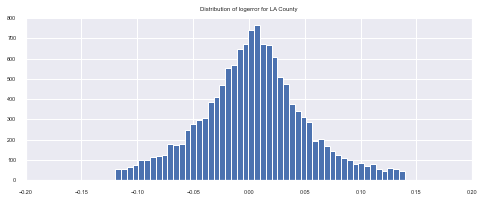

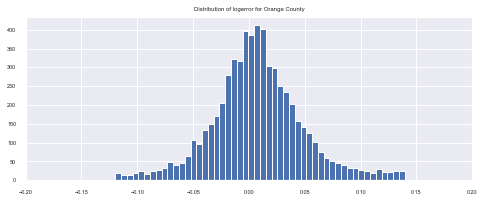

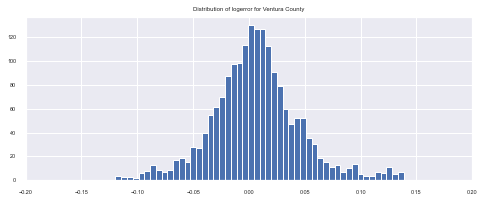

In [14]:
# examining logerror distribution by county (exclusive of outliers)

county_lst = list(train_imputed["county_by_fips"].unique())

for ele in county_lst:
    print(f'County: {ele}')
    print(f'logerror: {round(train_imputed[train_imputed["county_by_fips"] == ele].logerror.var(), 5)}')
    print('-------------------------')

    plt.figure(figsize = (8,3))
    plt.xlim(-.2, .2)

    plt.title('Distribution of logerror for {}'.format(ele))
    plt.hist(train_imputed[train_imputed["county_by_fips"] == ele].logerror, bins = 50)

----
**```Hypothesis Question Number 1: Is there a difference in log error across transaction month?```**

Given the many economic factors that may influence the housing market, I belive that this could also lead to challenges in accurate and timely home evaluations - thus leading to over, or under estimating a home's true value.

**Null Hypothesis:** "There's **not** a statistical logerror difference across transaction months."

**Alternative Hypothesis:** "There **is** a statistical logerror difference across transaction months."

$\alpha$: 0.05

- Monthly logerror variances are relatively equal.

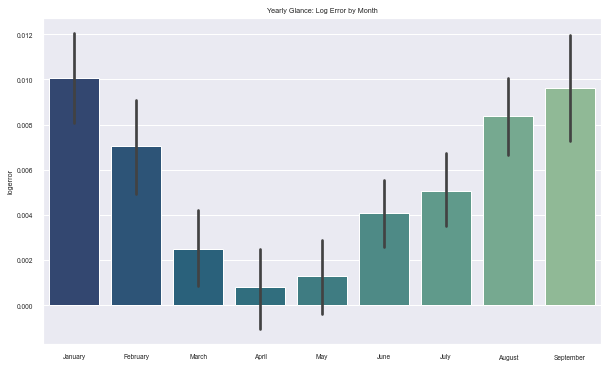

In [15]:
# plotting monthly logerror

plt.figure(figsize = (10, 6))
sns.set(font_scale = 0.6)
sns.barplot(x = "transaction_month",
    y = "logerror", 
    data = train_imputed,
    order = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September'],
    palette = "crest_r",
    ci = 95)


plt.title("Yearly Glance: Log Error by Month")
plt.xlabel(None)
plt.show()

In [16]:
# let's create quarter columns too

# train dataset
train_imputed["q1_transaction"] = (train_imputed["transaction_month"] == "January") | (train_imputed["transaction_month"] == "February") | (train_imputed["transaction_month"] == "March")
train_imputed["q2_transaction"] = (train_imputed["transaction_month"] == "April") | (train_imputed["transaction_month"] == "May") | (train_imputed["transaction_month"] == "June")
train_imputed["q3_transaction"] = (train_imputed["transaction_month"] == "July") | (train_imputed["transaction_month"] == "August") | (train_imputed["transaction_month"] == "September")

# validate dataset
validate_imputed["q1_transaction"] = (validate_imputed["transaction_month"] == "January") | (validate_imputed["transaction_month"] == "February") | (validate_imputed["transaction_month"] == "March")
validate_imputed["q2_transaction"] = (validate_imputed["transaction_month"] == "April") | (validate_imputed["transaction_month"] == "May") | (validate_imputed["transaction_month"] == "June")
validate_imputed["q3_transaction"] = (validate_imputed["transaction_month"] == "July") | (validate_imputed["transaction_month"] == "August") | (validate_imputed["transaction_month"] == "September")

# test dataset
test_imputed["q1_transaction"] = (test_imputed["transaction_month"] == "January") | (test_imputed["transaction_month"] == "February") | (test_imputed["transaction_month"] == "March")
test_imputed["q2_transaction"] = (test_imputed["transaction_month"] == "April") | (test_imputed["transaction_month"] == "May") | (test_imputed["transaction_month"] == "June")
test_imputed["q3_transaction"] = (test_imputed["transaction_month"] == "July") | (test_imputed["transaction_month"] == "August") | (test_imputed["transaction_month"] == "September")

In [17]:
# melting quarter transaction columns

train_imputed["transaction_quarter"] = train_imputed[["q1_transaction", "q2_transaction", "q3_transaction"]].idxmax(1).to_frame('transaction_quarter')
validate_imputed["transaction_quarter"] = validate_imputed[["q1_transaction", "q2_transaction", "q3_transaction"]].idxmax(1).to_frame('transaction_quarter')
test_imputed["transaction_quarter"] = test_imputed[["q1_transaction", "q2_transaction", "q3_transaction"]].idxmax(1).to_frame('transaction_quarter')

# dropping redundant columns

train_imputed.drop(columns = ["q1_transaction", "q2_transaction", "q3_transaction"], inplace = True)
validate_imputed.drop(columns = ["q1_transaction", "q2_transaction", "q3_transaction"], inplace = True)
test_imputed.drop(columns = ["q1_transaction", "q2_transaction", "q3_transaction"], inplace = True)

train.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,home_age,transaction_month,transaction_quarter
49143,11279487,74239.00,-0.02,1.00,3.00,943.00,LA County,34695455.00,-118167705.00,7834.00,0100,60379010.08,1955.00,62.00,September,q3_transaction
18505,14235131,426984.00,-0.02,2.50,3.00,1436.00,Orange County,33794700.00,-117823000.00,2490.00,122,60590758.15,1989.00,28.00,April,q2_transaction
1594,12461319,399808.00,0.02,2.00,3.00,1470.00,LA County,33843316.00,-118173744.00,6336.00,0100,60375715.03,1942.00,75.00,January,q1_transaction
35506,14139772,71763.00,-0.06,2.00,3.00,1403.00,Orange County,33905449.00,-117892188.00,7770.00,122,60590015.05,1963.00,54.00,June,q2_transaction
11229,14491761,354226.00,-0.03,1.00,2.00,936.00,Orange County,33625277.00,-117662397.00,5000.00,122,60590320.28,1972.00,45.00,March,q1_transaction


In [18]:
# ANOVA hypothesis test for: transactions by quarter

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["transaction_month"] == "January"].logerror,
    train_imputed[train_imputed["transaction_month"] == "February"].logerror,
    train_imputed[train_imputed["transaction_month"] == "March"].logerror,
    train_imputed[train_imputed["transaction_month"] == "April"].logerror,
    train_imputed[train_imputed["transaction_month"] == "May"].logerror,
    train_imputed[train_imputed["transaction_month"] == "June"].logerror,
    train_imputed[train_imputed["transaction_month"] == "July"].logerror,
    train_imputed[train_imputed["transaction_month"] == "August"].logerror,
    train_imputed[train_imputed["transaction_month"] == "September"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 13.19602
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
```Hypothesis Question Number 2: Is there a difference in logerror across home sizes (binned living sq-feet)?```

**Null Hypothesis:** There's **not** a statistical logerror difference across home sizes."

**Althernative Hypothesis:** There **is** a statistical logerror difference across home sizes."

$\alpha$: 0.05

- Home Size logerror variances are not equal.

<u>**Binned Home Sizes:**</u>

* 360 - 1241 sq. ft (smallest)
* 1241 - 1566 sq. ft
* 1566 - 2037 sq. ft
* 2037 - 3855 sq ft (largest)

In [19]:
# generating new home size column

sq_ft_labels = ["360_to_1240_sqfeet", "1241_to_1565_sqfeet", "1566_to_2036_sqfeet", "2037_to_3855_sqfeet"]

train_imputed["living_sqfeet_binned"] = pd.qcut(
    train_imputed["living_sq_feet"], \
    q = 4, \
    labels = sq_ft_labels)

validate_imputed["living_sqfeet_binned"] = pd.qcut(
    validate_imputed["living_sq_feet"], \
    q = 4, \
    labels = sq_ft_labels)

test_imputed["living_sqfeet_binned"] = pd.qcut(
    test_imputed["living_sq_feet"], \
    q = 4, \
    labels = sq_ft_labels)

train_imputed.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,home_age,transaction_month,transaction_quarter,living_sqfeet_binned
49143,11279487,74239.00,-0.02,1.00,3.00,943.00,LA County,34695455.00,-118167705.00,7834.00,0100,60379010.08,1955.00,62.00,September,q3_transaction,360_to_1240_sqfeet
18505,14235131,426984.00,-0.02,2.50,3.00,1436.00,Orange County,33794700.00,-117823000.00,2490.00,122,60590758.15,1989.00,28.00,April,q2_transaction,1241_to_1565_sqfeet
1594,12461319,399808.00,0.02,2.00,3.00,1470.00,LA County,33843316.00,-118173744.00,6336.00,0100,60375715.03,1942.00,75.00,January,q1_transaction,1241_to_1565_sqfeet
35506,14139772,71763.00,-0.06,2.00,3.00,1403.00,Orange County,33905449.00,-117892188.00,7770.00,122,60590015.05,1963.00,54.00,June,q2_transaction,1241_to_1565_sqfeet
11229,14491761,354226.00,-0.03,1.00,2.00,936.00,Orange County,33625277.00,-117662397.00,5000.00,122,60590320.28,1972.00,45.00,March,q1_transaction,360_to_1240_sqfeet


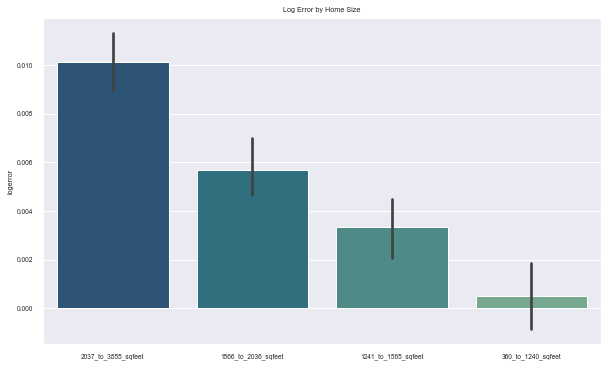

In [20]:
# plotting logerror by home size

plt.figure(figsize = (10, 6))
sns.set(font_scale = 0.6)
sns.barplot(x = "living_sqfeet_binned",
    y = "logerror", 
    data = train_imputed,
    order = [
        "2037_to_3855_sqfeet", 
        "1566_to_2036_sqfeet", 
        "1241_to_1565_sqfeet",
        "360_to_1240_sqfeet"],
    palette = "crest_r",
    ci = 95)

plt.title("Log Error by Home Size")
plt.xlabel(None)
plt.show()

In [21]:
# ANOVA hypothesis test for: home sizes

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["living_sqfeet_binned"] == "360_to_1240_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "1241_to_1565_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "1566_to_2036_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "2037_to_3855_sqfeet"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 43.50843
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
```Hypothesis Question Number 3: Is there a difference in logerror across building era?```

**Null Hypothesis:** There's **not** a statistical logerror difference across building era."

**Althernative Hypothesis:** There **is** a statistical logerror difference across building era."

$\alpha$: 0.05

- Build Era logerror variances are not equal.

<u>**Home Building Eras:**</u>

- 1977 - 2015: "new century"
- 1960 - 1976: "late 20th century" 
- 1950 - 1959: "mid 20th century"
- 1907 - 1949: "early 20th century"

In [22]:
# creating new home build era column 

age_labels = ["new_century", "late_20th_century", "mid_20th_century", "early_20th_century"]

train_imputed["home_age_binned"] = pd.qcut(
    train_imputed["home_age"],
    q = 4,
    labels = age_labels)

validate_imputed["home_age_binned"] = pd.qcut(
    validate_imputed["home_age"], 
    q = 4, 
    labels = age_labels)

test_imputed["home_age_binned"] = pd.qcut(
    test_imputed["home_age"], 
    q = 4, 
    labels = age_labels)

train_imputed.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,home_age,transaction_month,transaction_quarter,living_sqfeet_binned,home_age_binned
49143,11279487,74239.00,-0.02,1.00,3.00,943.00,LA County,34695455.00,-118167705.00,7834.00,0100,60379010.08,1955.00,62.00,September,q3_transaction,360_to_1240_sqfeet,mid_20th_century
18505,14235131,426984.00,-0.02,2.50,3.00,1436.00,Orange County,33794700.00,-117823000.00,2490.00,122,60590758.15,1989.00,28.00,April,q2_transaction,1241_to_1565_sqfeet,new_century
1594,12461319,399808.00,0.02,2.00,3.00,1470.00,LA County,33843316.00,-118173744.00,6336.00,0100,60375715.03,1942.00,75.00,January,q1_transaction,1241_to_1565_sqfeet,early_20th_century
35506,14139772,71763.00,-0.06,2.00,3.00,1403.00,Orange County,33905449.00,-117892188.00,7770.00,122,60590015.05,1963.00,54.00,June,q2_transaction,1241_to_1565_sqfeet,late_20th_century
11229,14491761,354226.00,-0.03,1.00,2.00,936.00,Orange County,33625277.00,-117662397.00,5000.00,122,60590320.28,1972.00,45.00,March,q1_transaction,360_to_1240_sqfeet,late_20th_century


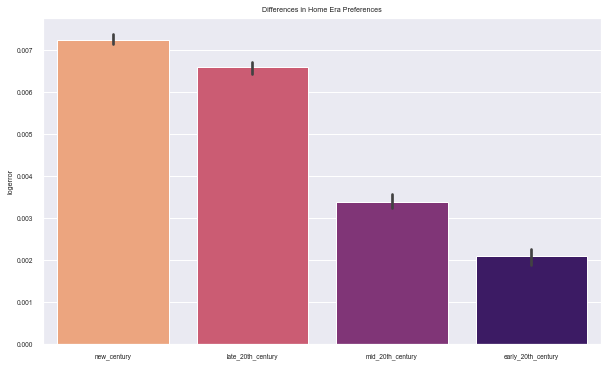

In [23]:
# plotting logerror by building era w/20% Confidence Interval

plt.figure(figsize = (10, 6))
sns.set(font_scale = 0.6)
sns.barplot(
    x = "home_age_binned",
    y = "logerror",
    data = train_imputed,
    order = ["new_century", "late_20th_century", "mid_20th_century", "early_20th_century"], 
    ci = 20,
    palette = "magma_r")

plt.title("Differences in Home Era Preferences")
plt.xlabel(None)
plt.show()

In [24]:
# ANOVA hypothesis test for: home era

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["home_age_binned"] == "new_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "late_20th_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "mid_20th_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "early_20th_century"].logerror)
    

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 15.70254
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


-----
### <u>``Scaling Data and Clustering Features``</u>

**Highlights:**

In [25]:
# creating dummy variables for clustering

train_dummy, validate_dummy, test_dummy = get_dummy_dataframes(train_imputed, validate_imputed, test_imputed)
train_dummy.head()

,parcel_id,home_value,logerror,living_sq_feet,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,...,county_by_fips_LA County,county_by_fips_Orange County,county_by_fips_Ventura County,living_sqfeet_binned_360_to_1240_sqfeet,living_sqfeet_binned_1241_to_1565_sqfeet,living_sqfeet_binned_1566_to_2036_sqfeet,living_sqfeet_binned_2037_to_3855_sqfeet,transaction_quarter_q1_transaction,transaction_quarter_q2_transaction,transaction_quarter_q3_transaction
49143,11279487,74239.00,-0.02,943.00,34695455.00,-118167705.00,7834.00,0100,60379010.08,1955.00,...,True,False,False,True,False,False,False,False,False,True
18505,14235131,426984.00,-0.02,1436.00,33794700.00,-117823000.00,2490.00,122,60590758.15,1989.00,...,False,True,False,False,True,False,False,False,True,False
1594,12461319,399808.00,0.02,1470.00,33843316.00,-118173744.00,6336.00,0100,60375715.03,1942.00,...,True,False,False,False,True,False,False,True,False,False
35506,14139772,71763.00,-0.06,1403.00,33905449.00,-117892188.00,7770.00,122,60590015.05,1963.00,...,False,True,False,False,True,False,False,False,True,False
11229,14491761,354226.00,-0.03,936.00,33625277.00,-117662397.00,5000.00,122,60590320.28,1972.00,...,False,True,False,True,False,False,False,True,False,False


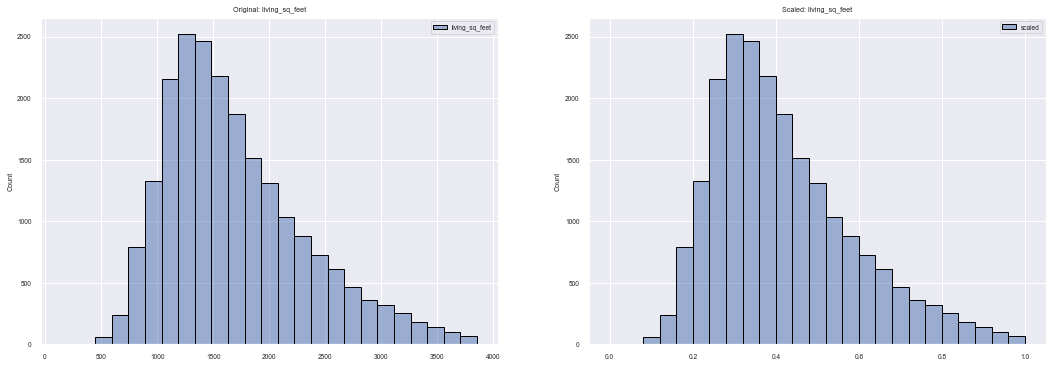

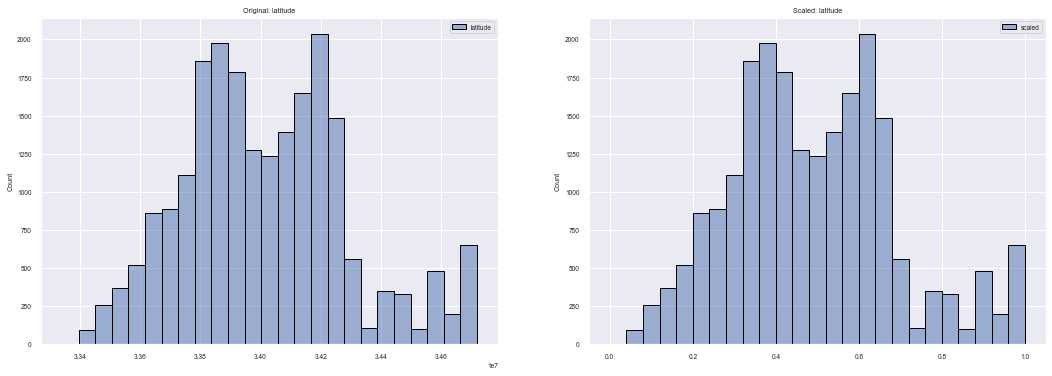

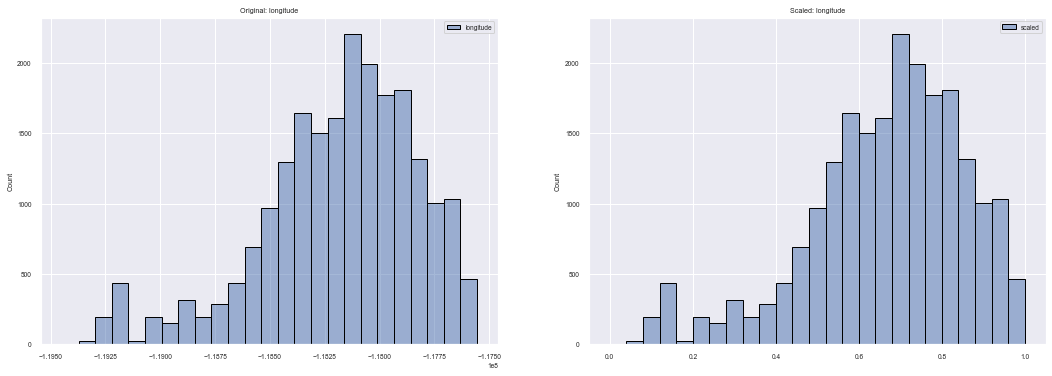

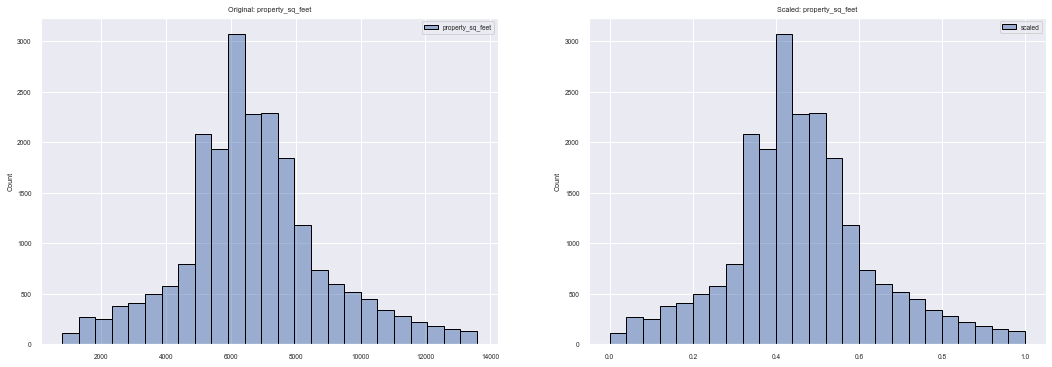

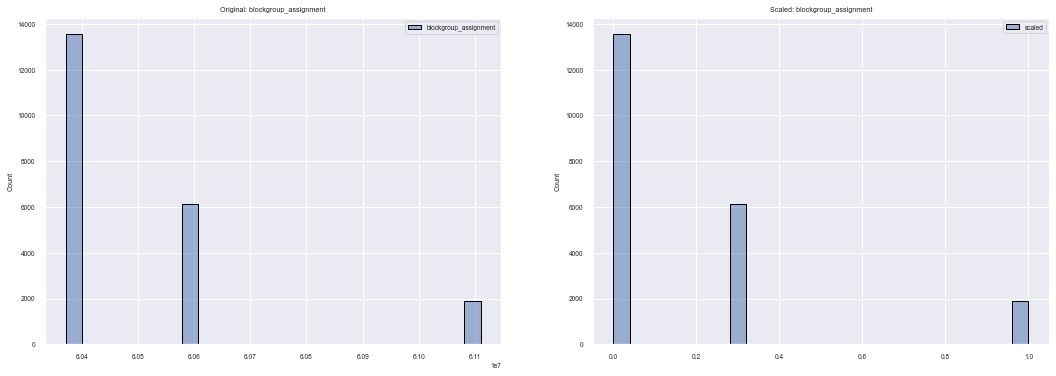

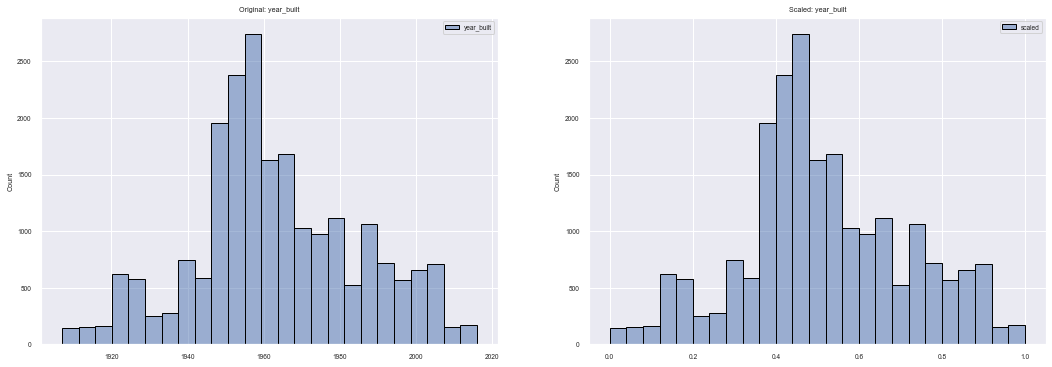

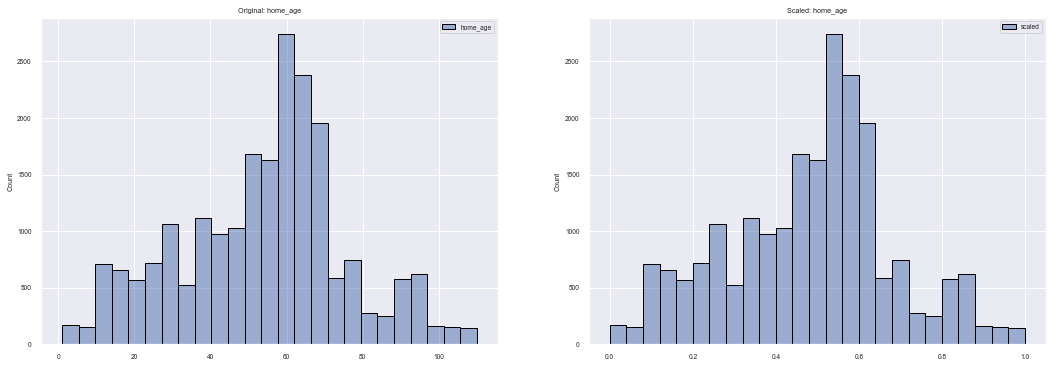

In [26]:
# scaling plot using sklearn's MinMaxScaler

cont_lst = train_dummy.select_dtypes(exclude = ["object", "category", "uint8", "int64", "bool"]).columns.tolist()
cont_lst = [ele for ele in cont_lst if ele not in ("logerror", "home_value")]

for col in cont_lst:
    scaler = MinMaxScaler()
    scaler.fit(train_dummy[[col]])

    x_scaled = scaler.transform(train_dummy[[col]])

    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    sns.histplot(train_dummy[[col]], bins = 25, edgecolor = 'black', label = col)
    
    plt.title(f'Original: {col}')
    plt.legend()

    plt.subplot(122)
    ax = sns.histplot(x_scaled, bins=25, edgecolor = 'black', label = "scaled")
    
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Scaled: {col}')
    plt.legend()

In [27]:
# scaling necessary features in datasets

scaler = MinMaxScaler()
scaler.fit(train_dummy[cont_lst])

# dummy datasets
train_dummy[cont_lst] = scaler.transform(train_dummy[cont_lst])
validate_dummy[cont_lst] = scaler.transform(validate_dummy[cont_lst])
test_dummy[cont_lst] = scaler.transform(test_dummy[cont_lst])

# non-dummy datasets
train_imputed[cont_lst] = scaler.transform(train_imputed[cont_lst])
validate_imputed[cont_lst] = scaler.transform(validate_imputed[cont_lst])
test_imputed[cont_lst] = scaler.transform(test_imputed[cont_lst])

train_dummy.head()

,parcel_id,home_value,logerror,living_sq_feet,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,...,county_by_fips_LA County,county_by_fips_Orange County,county_by_fips_Ventura County,living_sqfeet_binned_360_to_1240_sqfeet,living_sqfeet_binned_1241_to_1565_sqfeet,living_sqfeet_binned_1566_to_2036_sqfeet,living_sqfeet_binned_2037_to_3855_sqfeet,transaction_quarter_q1_transaction,transaction_quarter_q2_transaction,transaction_quarter_q3_transaction
49143,11279487,74239.00,-0.02,0.21,0.98,0.68,0.55,0100,0.01,0.44,...,True,False,False,True,False,False,False,False,False,True
18505,14235131,426984.00,-0.02,0.35,0.33,0.86,0.13,122,0.30,0.75,...,False,True,False,False,True,False,False,False,True,False
1594,12461319,399808.00,0.02,0.36,0.36,0.67,0.43,0100,0.01,0.32,...,True,False,False,False,True,False,False,True,False,False
35506,14139772,71763.00,-0.06,0.34,0.41,0.82,0.55,122,0.30,0.51,...,False,True,False,False,True,False,False,False,True,False
11229,14491761,354226.00,-0.03,0.21,0.21,0.94,0.33,122,0.30,0.60,...,False,True,False,True,False,False,False,True,False,False


----
#### **``Cluster Number 1: Monthly Cluster``**

In [28]:
# setting features to cluster on 

X_month = train_dummy[[
    'home_age',
    'transaction_month_January',
    'transaction_month_February',
    'transaction_month_March',
    'transaction_month_April',
    'transaction_month_May',
    'transaction_month_June',
    'transaction_month_July',
    'transaction_month_August',
    'transaction_month_September'
    ]]

# validate df
X_val = validate_dummy[[
    'home_age',
    'transaction_month_January',
    'transaction_month_February',
    'transaction_month_March',
    'transaction_month_April',
    'transaction_month_May',
    'transaction_month_June',
    'transaction_month_July',
    'transaction_month_August',
    'transaction_month_September'
    ]]

# test df
X_test = test_dummy[[
    'home_age',
    'transaction_month_January',
    'transaction_month_February',
    'transaction_month_March',
    'transaction_month_April',
    'transaction_month_May',
    'transaction_month_June',
    'transaction_month_July',
    'transaction_month_August',
    'transaction_month_September'
    ]]

X_month.head()

,home_age,transaction_month_January,transaction_month_February,transaction_month_March,transaction_month_April,transaction_month_May,transaction_month_June,transaction_month_July,transaction_month_August,transaction_month_September
49143,0.56,False,False,False,False,False,False,False,False,True
18505,0.25,False,False,False,True,False,False,False,False,False
1594,0.68,True,False,False,False,False,False,False,False,False
35506,0.49,False,False,False,False,False,True,False,False,False
11229,0.40,False,False,True,False,False,False,False,False,False


In [29]:
# initial fitting of KMeans cluster

kmeans = KMeans(n_clusters = 9)
kmeans.fit(X_month)

train_clusters = kmeans.predict(X_month)

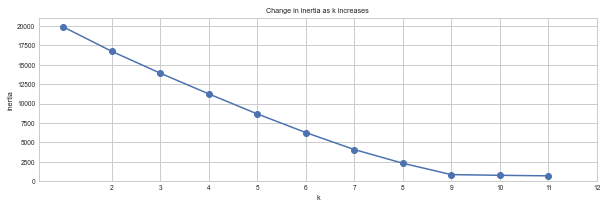

In [30]:
# KMeans Elbow-method

with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_month).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.ylim(0, 21000)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

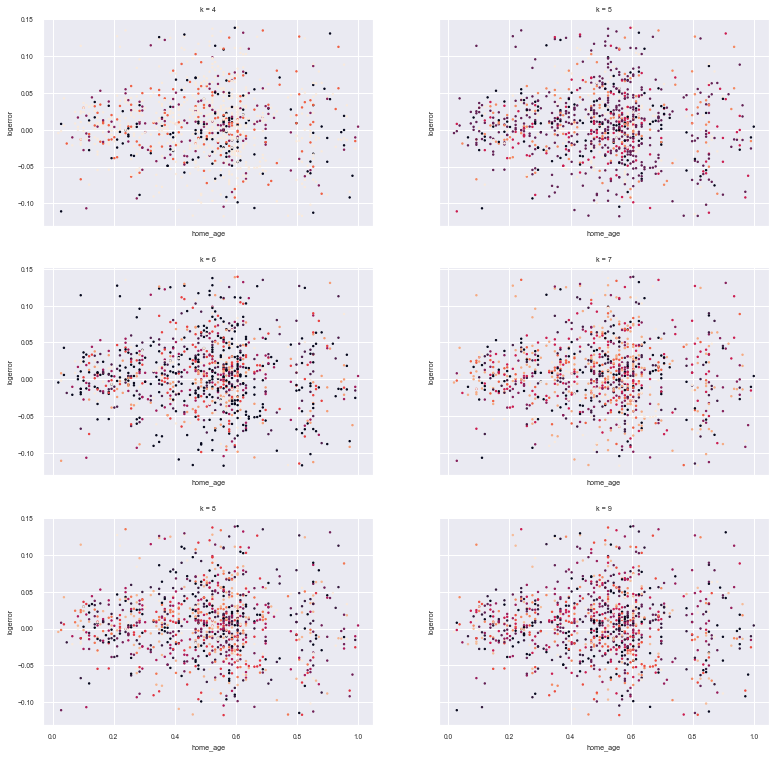

In [31]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(3, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(4, 13)):
    X1 = X_month.sample(1000, random_state = 14)

    # creating and fitting KMeans
    clusters = KMeans(k).fit(X1).predict(X1)

    X1["logerror"] = train_dummy["logerror"]

    ax.scatter(
        X1["home_age"],
        X1["logerror"],
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'home_age', ylabel = 'logerror')

In [32]:
# creating cluster for ea. dataset 

train_month_clusters = kmeans.predict(X_month)
val_month_clusters = kmeans.predict(X_val)
test_month_clusters = kmeans.predict(X_test)

pd.DataFrame(train_month_clusters).rename(columns = {0: "Cluster Sample"}).sample(10, random_state = 14)

,Cluster Sample
7593,0
13975,2
14841,2
6154,3
2726,4
4773,3
9765,1
9591,0
17098,0
10661,4


In [33]:
# adding clusters back to original datasets

train_imputed["month_clusters"] = train_month_clusters
validate_imputed["month_clusters"] = val_month_clusters
test_imputed["month_clusters"] = test_month_clusters

train_imputed.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,home_age,transaction_month,transaction_quarter,living_sqfeet_binned,home_age_binned,month_clusters
49143,11279487,74239.00,-0.02,1.00,3.00,0.21,LA County,0.98,0.68,0.55,0100,0.01,0.44,0.56,September,q3_transaction,360_to_1240_sqfeet,mid_20th_century,8
18505,14235131,426984.00,-0.02,2.50,3.00,0.35,Orange County,0.33,0.86,0.13,122,0.30,0.75,0.25,April,q2_transaction,1241_to_1565_sqfeet,new_century,5
1594,12461319,399808.00,0.02,2.00,3.00,0.36,LA County,0.36,0.67,0.43,0100,0.01,0.32,0.68,January,q1_transaction,1241_to_1565_sqfeet,early_20th_century,6
35506,14139772,71763.00,-0.06,2.00,3.00,0.34,Orange County,0.41,0.82,0.55,122,0.30,0.51,0.49,June,q2_transaction,1241_to_1565_sqfeet,late_20th_century,0
11229,14491761,354226.00,-0.03,1.00,2.00,0.21,Orange County,0.21,0.94,0.33,122,0.30,0.60,0.40,March,q1_transaction,360_to_1240_sqfeet,late_20th_century,3


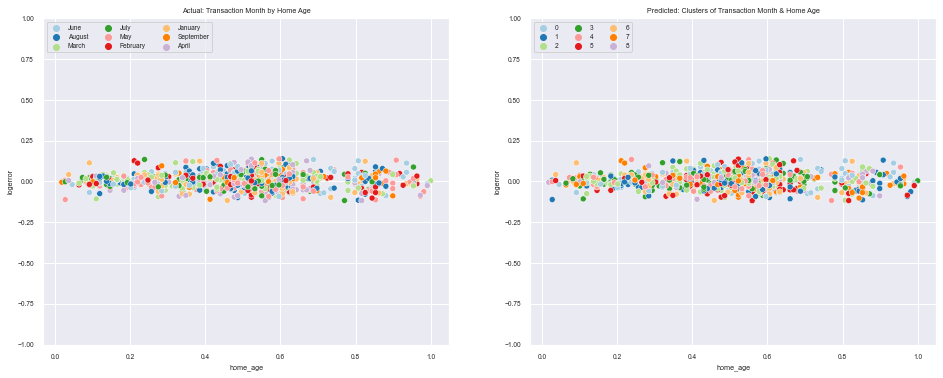

In [34]:
# seeing how month clusters compare against actual month and home age

sns.set(font_scale = 0.6)
plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(1000, random_state = 14), 
        hue = "transaction_month",
        # hue_order = [
        # 'January',
        # 'August',
        # 'April',
        # 'June',
        # 'May',
        # 'July',
        # 'March',
        # 'February',
        # 'September'],
        palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
)

plt.title("Actual: Transaction Month by Home Age")
plt.legend(loc = 'upper left', ncol = 3)
plt.ylim(-1, 1)

plt.subplot(122)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(1000, random_state = 14), 
        hue = "month_clusters",
        # hue_order = [0, 1, 2, 3, 4, 5, 6, 7, 8],
        palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
)

plt.title("Predicted: Clusters of Transaction Month & Home Age")
plt.legend(loc = 'upper left', ncol = 3)
plt.ylim(-1, 1)
plt.show()

----
#### **``Cluster Number 2: Home Size Cluster``**

In [35]:
# # setting features to cluster on 

X_home_size = train_dummy[[ 
    'home_age',
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet'
]]

val_home_size = validate_dummy[[ 
    'home_age',
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet'
]]

test_home_size = test_dummy[[ 
    'home_age',
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet'
]]

X_home_size.head()

,home_age,living_sqfeet_binned_360_to_1240_sqfeet,living_sqfeet_binned_1241_to_1565_sqfeet,living_sqfeet_binned_1566_to_2036_sqfeet,living_sqfeet_binned_2037_to_3855_sqfeet
49143,0.56,True,False,False,False
18505,0.25,False,True,False,False
1594,0.68,False,True,False,False
35506,0.49,False,True,False,False
11229,0.40,True,False,False,False


In [36]:
# creating the KMeans cluster object

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_home_size)

clusters = kmeans.predict(X_home_size)

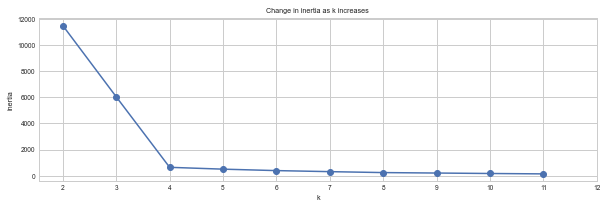

In [37]:
# KMeans Elbow-method

with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_home_size).inertia_ for k in range(2, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

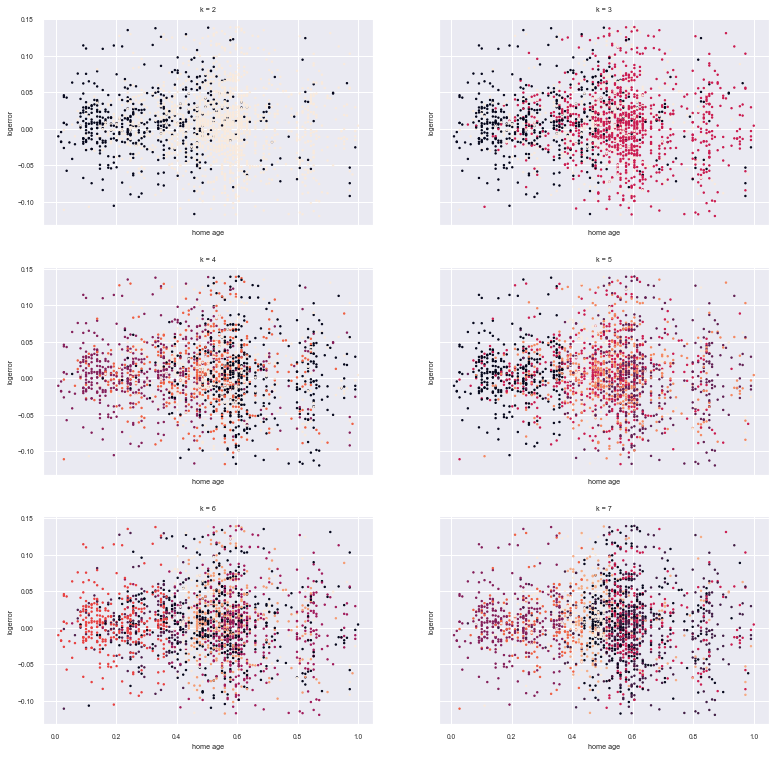

In [38]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(3, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 8)):
    # creating and fitting KMeans
    X2 = X_home_size.sample(2000, random_state = 14)
    clusters = KMeans(k).fit(X2).predict(X2)

    X2["logerror"] = train_dummy["logerror"]

    ax.scatter(
        X2["home_age"], 
        X2["logerror"], 
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'home age', ylabel = 'logerror')

In [39]:
# creating clusters for ea. dataset

train_size_clusters = kmeans.predict(X_home_size)
val_size_clusters = kmeans.predict(val_home_size)
test_size_clusters = kmeans.predict(test_home_size)

pd.DataFrame(train_size_clusters).rename(columns = {0: "Cluster Sample"}).sample(10, random_state = 54)

,Cluster Sample
19548,0
15320,0
258,3
14675,2
18129,3
21474,0
15334,1
12461,1
7951,1
6109,2


In [40]:
# adding clusters to original datasets

train_imputed["size_clusters"] = train_size_clusters
validate_imputed["size_clusters"] = val_size_clusters
test_imputed["size_clusters"] = test_size_clusters

train_imputed.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,home_age,transaction_month,transaction_quarter,living_sqfeet_binned,home_age_binned,month_clusters,size_clusters
49143,11279487,74239.00,-0.02,1.00,3.00,0.21,LA County,0.98,0.68,0.55,0100,0.01,0.44,0.56,September,q3_transaction,360_to_1240_sqfeet,mid_20th_century,8,1
18505,14235131,426984.00,-0.02,2.50,3.00,0.35,Orange County,0.33,0.86,0.13,122,0.30,0.75,0.25,April,q2_transaction,1241_to_1565_sqfeet,new_century,5,0
1594,12461319,399808.00,0.02,2.00,3.00,0.36,LA County,0.36,0.67,0.43,0100,0.01,0.32,0.68,January,q1_transaction,1241_to_1565_sqfeet,early_20th_century,6,0
35506,14139772,71763.00,-0.06,2.00,3.00,0.34,Orange County,0.41,0.82,0.55,122,0.30,0.51,0.49,June,q2_transaction,1241_to_1565_sqfeet,late_20th_century,0,0
11229,14491761,354226.00,-0.03,1.00,2.00,0.21,Orange County,0.21,0.94,0.33,122,0.30,0.60,0.40,March,q1_transaction,360_to_1240_sqfeet,late_20th_century,3,1


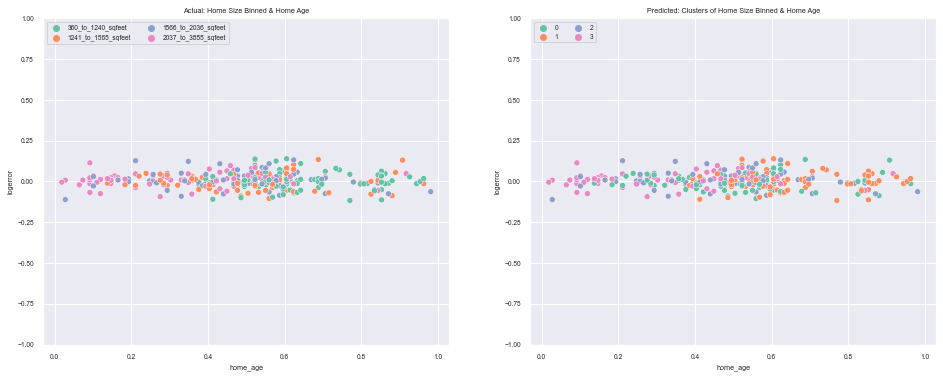

In [41]:
# seeing how clusters compare against actual month & home age plots

plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(300, random_state = 14),
        hue = "living_sqfeet_binned",
        # hue_order = ["360_to_1240_sqfeet", "1241_to_1565_sqfeet", "1566_to_2036_sqfeet", "2037_to_3855_sqfeet"],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)

plt.title("Actual: Home Size Binned & Home Age")
plt.legend(loc = 'upper left', ncol = 2)
plt.ylim(-1, 1)

plt.subplot(122)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(300, random_state = 14), 
        hue = "size_clusters",
        # hue_order = [0, 1, 2, 3],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)

plt.title("Predicted: Clusters of Home Size Binned & Home Age")
plt.legend(loc = 'upper left', ncol = 2)
plt.ylim(-1, 1)
plt.show()

----
#### **``Cluster Number 3: Build Era Clusters``**

In [42]:
# # setting features to cluster on 

X_era = train_dummy[[
    'living_sq_feet',
    'home_age_binned_new_century',
    'home_age_binned_late_20th_century',
    'home_age_binned_mid_20th_century',
    'home_age_binned_early_20th_century']]

val_era = validate_dummy[[
    'living_sq_feet',
    'home_age_binned_new_century',
    'home_age_binned_late_20th_century',
    'home_age_binned_mid_20th_century',
    'home_age_binned_early_20th_century']]

test_era = test_dummy[[
    'living_sq_feet',
    'home_age_binned_new_century',
    'home_age_binned_late_20th_century',
    'home_age_binned_mid_20th_century',
    'home_age_binned_early_20th_century']]

X_era.head()

,living_sq_feet,home_age_binned_new_century,home_age_binned_late_20th_century,home_age_binned_mid_20th_century,home_age_binned_early_20th_century
49143,0.21,False,False,True,False
18505,0.35,True,False,False,False
1594,0.36,False,False,False,True
35506,0.34,False,True,False,False
11229,0.21,False,True,False,False


In [43]:
# creating the KMeans cluster object

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_era)

clusters = kmeans.predict(X_era)

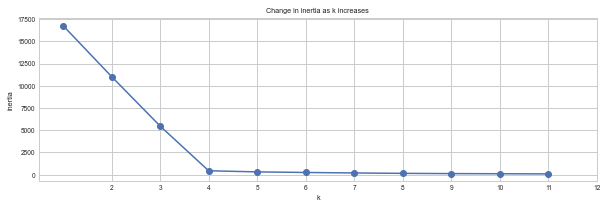

In [44]:
# KMeans Elbow-method

with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_era).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

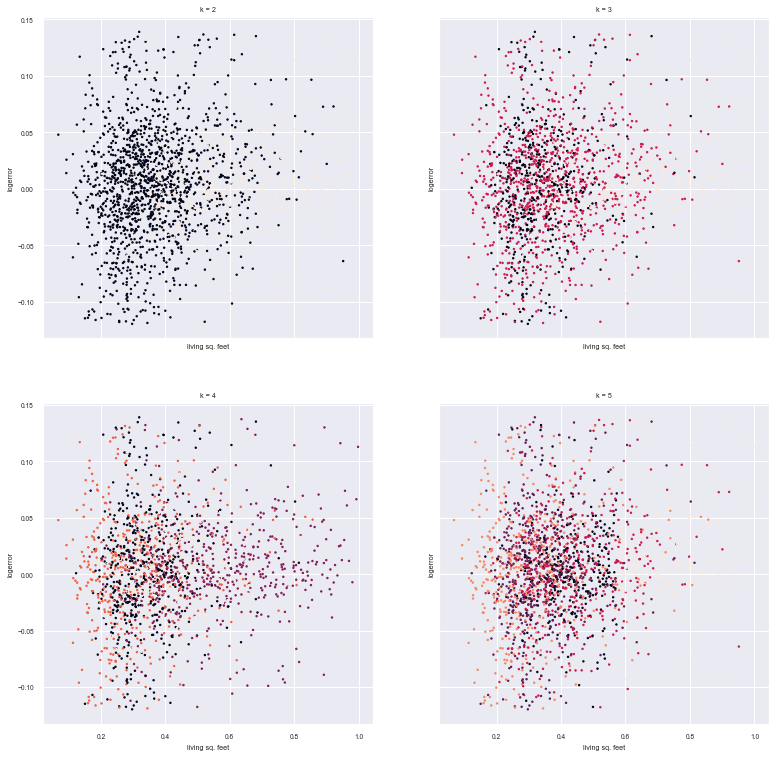

In [45]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):

    X3 = X_era.sample(2000, random_state = 54)

    # creating and fitting KMeans
    clusters = KMeans(k).fit(X3).predict(X3)

    X3["logerror"] = train_dummy["logerror"]

    ax.scatter(
        X3["living_sq_feet"], 
        X3["logerror"], 
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'living sq. feet', ylabel = 'logerror')

In [46]:
train_era_clusters = kmeans.predict(X_era)
validate_era_clusters = kmeans.predict(val_era)
test_era_clusters = kmeans.predict(test_era)

pd.DataFrame(train_era_clusters).rename(columns = {0: "Cluster Sample"}).head(10)

,Cluster Sample
0,2
1,1
2,0
3,3
4,3
5,2
6,0
7,1
8,3
9,1


In [47]:
# adding clusters to original datasets

train_imputed["era_clusters"] = train_era_clusters
validate_imputed["era_clusters"] = validate_era_clusters
test_imputed["era_clusters"] = test_era_clusters

train_imputed.head()

,parcel_id,home_value,logerror,bathroom_count,bedroom_count,living_sq_feet,county_by_fips,latitude,longitude,property_sq_feet,...,blockgroup_assignment,year_built,home_age,transaction_month,transaction_quarter,living_sqfeet_binned,home_age_binned,month_clusters,size_clusters,era_clusters
49143,11279487,74239.00,-0.02,1.00,3.00,0.21,LA County,0.98,0.68,0.55,...,0.01,0.44,0.56,September,q3_transaction,360_to_1240_sqfeet,mid_20th_century,8,1,2
18505,14235131,426984.00,-0.02,2.50,3.00,0.35,Orange County,0.33,0.86,0.13,...,0.30,0.75,0.25,April,q2_transaction,1241_to_1565_sqfeet,new_century,5,0,1
1594,12461319,399808.00,0.02,2.00,3.00,0.36,LA County,0.36,0.67,0.43,...,0.01,0.32,0.68,January,q1_transaction,1241_to_1565_sqfeet,early_20th_century,6,0,0
35506,14139772,71763.00,-0.06,2.00,3.00,0.34,Orange County,0.41,0.82,0.55,...,0.30,0.51,0.49,June,q2_transaction,1241_to_1565_sqfeet,late_20th_century,0,0,3
11229,14491761,354226.00,-0.03,1.00,2.00,0.21,Orange County,0.21,0.94,0.33,...,0.30,0.60,0.40,March,q1_transaction,360_to_1240_sqfeet,late_20th_century,3,1,3


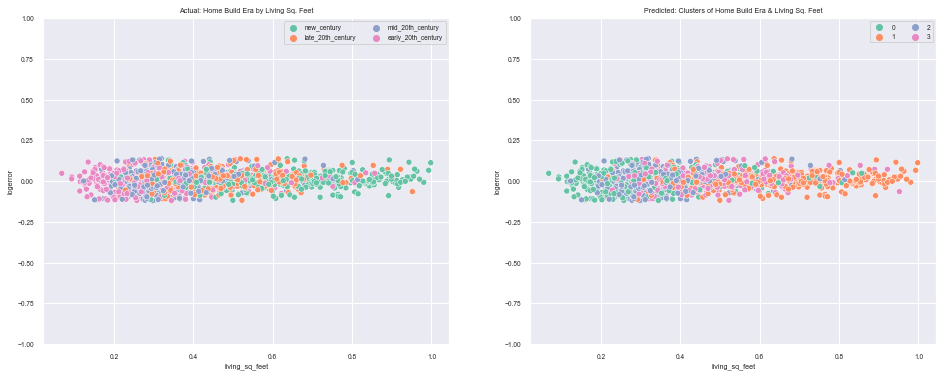

In [48]:
# seeing how clusters compare against actual month & home age plots

plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "living_sq_feet",
        y = "logerror",
        data = train_imputed.sample(2000, random_state = 54),
        hue = "home_age_binned",
        # hue_order = ["early_20th_century", "late_20th_century", "mid_20th_century", "new_century"],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)

plt.title("Actual: Home Build Era by Living Sq. Feet")
plt.legend(loc = 'upper right', ncol = 2)
plt.ylim(-1, 1)

plt.subplot(122)
sns.scatterplot(
        x = "living_sq_feet",
        y = "logerror",
        data = train_imputed.sample(2000, random_state = 54), 
        hue = "era_clusters",
        # hue_order = [0, 1, 2, 3],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)

plt.title("Predicted: Clusters of Home Build Era & Living Sq. Feet")
plt.legend(loc = 'upper right', ncol = 2)
plt.ylim(-1, 1)
plt.show()

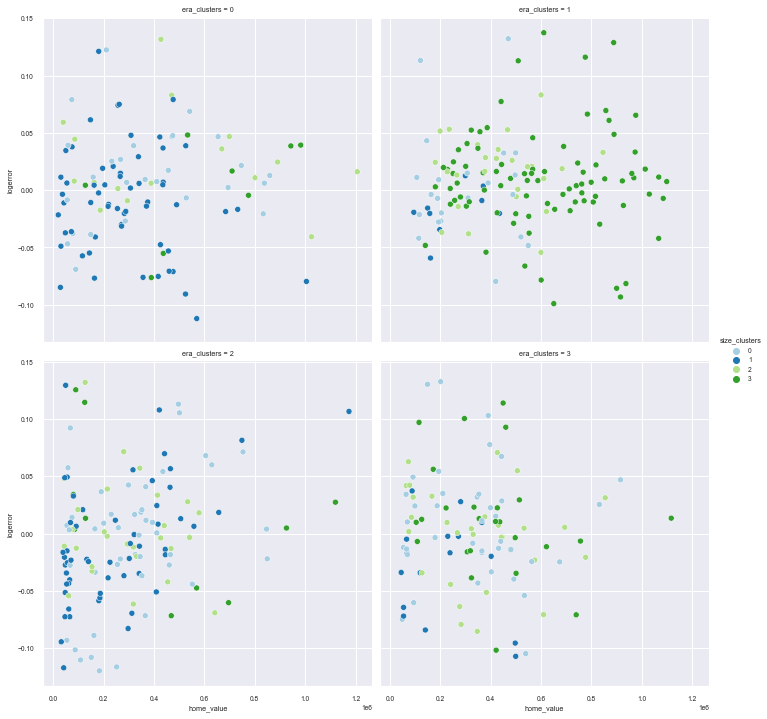

In [49]:
# plotting size and era clusters against actual home value

sns.relplot(
    data = train_imputed.sample(500, random_state = 54), 
    x = "home_value", 
    y = "logerror", 
    col = "era_clusters", 
    hue = "size_clusters",
    palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c'],
    col_wrap = 2)

plt.show()

----
### **``Modeling``**

In [50]:
# creating dummy dataframes with generated clusters for modeling

train_dummy, validate_dummy, test_dummy = get_cluster_dummy(train_imputed, validate_imputed, test_imputed)
print(f'dataframe shape: {train_dummy.shape}')
train_dummy.head()

dataframe shape: (21578, 62)


,parcel_id,home_value,logerror,living_sq_feet,latitude,longitude,property_sq_feet,county_zoning_code,blockgroup_assignment,year_built,...,month_clusters_7,month_clusters_8,era_clusters_0,era_clusters_1,era_clusters_2,era_clusters_3,size_clusters_0,size_clusters_1,size_clusters_2,size_clusters_3
49143,11279487,74239.00,-0.02,0.21,0.98,0.68,0.55,0100,0.01,0.44,...,False,True,False,False,True,False,False,True,False,False
18505,14235131,426984.00,-0.02,0.35,0.33,0.86,0.13,122,0.30,0.75,...,False,False,False,True,False,False,True,False,False,False
1594,12461319,399808.00,0.02,0.36,0.36,0.67,0.43,0100,0.01,0.32,...,False,False,True,False,False,False,True,False,False,False
35506,14139772,71763.00,-0.06,0.34,0.41,0.82,0.55,122,0.30,0.51,...,False,False,False,False,False,True,True,False,False,False
11229,14491761,354226.00,-0.03,0.21,0.21,0.94,0.33,122,0.30,0.60,...,False,False,False,False,False,True,False,True,False,False


In [51]:
# establishing a mean logerror baseline for train & validate datasets

train_dummy, validate_dummy = acquire.establish_baseline(train_dummy, validate_dummy)

Train baseline RMSE: 0.05
Validate baseline RMSE: 0.05

train shape: (21578, 62)
validate shape: (9249, 62)


----
#### ``2nd Data Split: Taking forward needed X variables and y (logerror) variable

In [52]:
# 2nd split: splitting larger datasets into x and y variables

X_train = train_dummy.drop(columns = [
    "logerror", 
    "home_value",
    'blockgroup_assignment',
    'parcel_id',
    'transaction_quarter',
    'county_zoning_code',
    'home_age_binned_new_century',               
    'home_age_binned_late_20th_century',             
    'home_age_binned_mid_20th_century',               
    'home_age_binned_early_20th_century',                 
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet',
    'transaction_month_April',                      
    'transaction_month_August',                      
    'transaction_month_February',                    
    'transaction_month_January',                     
    'transaction_month_July',                       
    'transaction_month_June',                        
    'transaction_month_March',                       
    'transaction_month_May',                         
    'transaction_month_September',
    'county_by_fips_LA County',
    'county_by_fips_Orange County',
    'county_by_fips_Ventura County',
    'bathroom_count_1.0',
    'bathroom_count_1.5',
    'bathroom_count_2.0',
    'bathroom_count_2.5',
    'bathroom_count_3.0',
    'bathroom_count_3.5',
    'bathroom_count_4.0',
    'bathroom_count_4.5',
    'bedroom_count_1.0',
    'bedroom_count_2.0',
    'bedroom_count_3.0',
    'bedroom_count_4.0',
    'bedroom_count_5.0',
    "year_built",
    "home_age",
    "living_sq_feet"
#     "property_sq_feet",
#     "latitude",
#     "longitude"
])

y_train = train_dummy["logerror"]

X_validate = validate_dummy.drop(columns = [
    "logerror", 
    "home_value",
    'blockgroup_assignment',
    'parcel_id',
    'transaction_quarter',
    'county_zoning_code',
    'home_age_binned_new_century',               
    'home_age_binned_late_20th_century',             
    'home_age_binned_mid_20th_century',               
    'home_age_binned_early_20th_century',                 
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet',
    'transaction_month_April',                      
    'transaction_month_August',                      
    'transaction_month_February',                    
    'transaction_month_January',                     
    'transaction_month_July',                       
    'transaction_month_June',                        
    'transaction_month_March',                       
    'transaction_month_May',                         
    'transaction_month_September',
    'county_by_fips_LA County',
    'county_by_fips_Orange County',
    'county_by_fips_Ventura County',
    'bathroom_count_1.0',
    'bathroom_count_1.5',
    'bathroom_count_2.0',
    'bathroom_count_2.5',
    'bathroom_count_3.0',
    'bathroom_count_3.5',
    'bathroom_count_4.0',
    'bathroom_count_4.5',
    'bedroom_count_1.0',
    'bedroom_count_2.0',
    'bedroom_count_3.0',
    'bedroom_count_4.0',
    'bedroom_count_5.0',
    "year_built",
    "home_age",
    "living_sq_feet"
#     "property_sq_feet",
#     "latitude",
#     "longitude"
])

y_validate = validate_dummy["logerror"]

X_test = test_dummy.drop(columns = [
    "logerror", 
    "home_value",
    'blockgroup_assignment',
    'parcel_id',
    'transaction_quarter',
    'county_zoning_code',
    'home_age_binned_new_century',               
    'home_age_binned_late_20th_century',             
    'home_age_binned_mid_20th_century',               
    'home_age_binned_early_20th_century',                 
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet',
    'transaction_month_April',                      
    'transaction_month_August',                      
    'transaction_month_February',                    
    'transaction_month_January',                     
    'transaction_month_July',                       
    'transaction_month_June',                        
    'transaction_month_March',                       
    'transaction_month_May',                         
    'transaction_month_September',
    'county_by_fips_LA County',
    'county_by_fips_Orange County',
    'county_by_fips_Ventura County',
    'bathroom_count_1.0',
    'bathroom_count_1.5',
    'bathroom_count_2.0',
    'bathroom_count_2.5',
    'bathroom_count_3.0',
    'bathroom_count_3.5',
    'bathroom_count_4.0',
    'bathroom_count_4.5',
    'bedroom_count_1.0',
    'bedroom_count_2.0',
    'bedroom_count_3.0',
    'bedroom_count_4.0',
    'bedroom_count_5.0',
    "year_built",
    "home_age",
    "living_sq_feet",
#     "property_sq_feet",
#     "latitude",
#     "longitude"
])
    
y_test = test_dummy["logerror"]

In [53]:
# checking the shape

print(X_train.shape)
print(y_train.shape)

(21578, 20)
(21578,)


In [54]:
acquire.recursive_feature_eliminate(X_train, y_train, 10).reset_index(drop = True)

,Feature,Ranking
0,latitude,1
1,size_clusters_1,1
2,month_clusters_8,1
3,month_clusters_7,1
4,month_clusters_5,1
5,month_clusters_6,1
6,month_clusters_1,1
7,longitude,1
8,month_clusters_2,1
9,size_clusters_3,1


In [55]:
# using sklearn's RFECV function to select best features to include
# initiating, and fitting

rfecv = RFECV(
    estimator = LinearRegression(),
    min_features_to_select = 5)

rfecv = rfecv.fit(X_train, y_train)

feature_lst = X_train.columns[rfecv.support_].tolist()
pd.DataFrame(feature_lst).rename(columns = {0: "Features"}).sort_values("Features").reset_index(drop = True)

,Features
0,era_clusters_0
1,era_clusters_1
2,era_clusters_2
3,era_clusters_3
4,latitude
5,longitude
6,month_clusters_0
7,month_clusters_1
8,month_clusters_2
9,month_clusters_3


In [56]:
# selecting only identified features from RFECV 

X_train = X_train[feature_lst]
X_validate = X_validate[feature_lst]
X_test = X_test[feature_lst]

# checking the shape 

print(f'dataframe shape: {X_train.shape}')
X_train.head()

dataframe shape: (21578, 20)


,latitude,longitude,property_sq_feet,month_clusters_0,month_clusters_1,month_clusters_2,month_clusters_3,month_clusters_4,month_clusters_5,month_clusters_6,month_clusters_7,month_clusters_8,era_clusters_0,era_clusters_1,era_clusters_2,era_clusters_3,size_clusters_0,size_clusters_1,size_clusters_2,size_clusters_3
49143,0.98,0.68,0.55,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False
18505,0.33,0.86,0.13,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False
1594,0.36,0.67,0.43,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False
35506,0.41,0.82,0.55,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
11229,0.21,0.94,0.33,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False


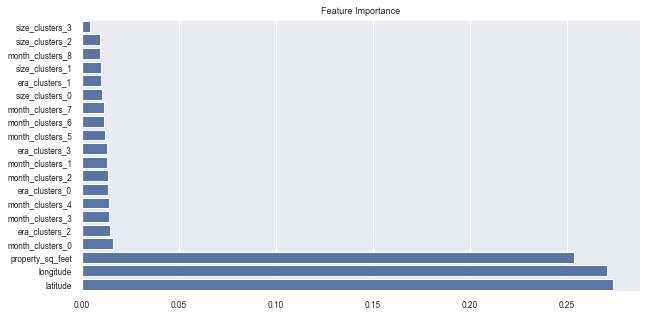

In [57]:
# calculating and plotting feature importance
plt.figure(figsize = (10, 5))
sns.set(style = "darkgrid", font_scale = .75)

rf = RandomForestRegressor(random_state = 123)
rf = rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()

sns.barplot(rf.feature_importances_[sorted_idx], X_train.columns[sorted_idx], orient = "h", color = "b")

plt.title("Feature Importance")
plt.show()

-----
#### <u>**``Model Plots and Evaluation on Validate Dataset:``**</u>

In [58]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

round_up(y_validate.mean(), 2)

0.01

In [59]:
# creating a dataframe w/X variables, y_train, and model predictions 

# creating the independent and dependent variables
X_var = pd.DataFrame(X_validate[feature_lst])
y_var = pd.DataFrame({'logerror actual': y_validate})
predictions = pd.concat([X_var, y_var], axis = 1).reset_index(drop = True)

# baseline mean predictions
baseline = round_up(y_validate.mean(), 2)
predictions["baseline_mean_predictions"] = baseline

predictions.head()

,latitude,longitude,property_sq_feet,month_clusters_0,month_clusters_1,month_clusters_2,month_clusters_3,month_clusters_4,month_clusters_5,month_clusters_6,...,era_clusters_0,era_clusters_1,era_clusters_2,era_clusters_3,size_clusters_0,size_clusters_1,size_clusters_2,size_clusters_3,logerror actual,baseline_mean_predictions
0,0.34,0.70,0.36,False,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,-0.04,0.01
1,0.71,0.54,0.33,True,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,0.03,0.01
2,0.60,0.59,0.49,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,0.05,0.01
3,0.64,0.47,0.98,False,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,0.06,0.01
4,0.57,0.67,0.16,False,False,False,False,True,False,False,...,True,False,False,False,True,False,False,False,0.09,0.01


In [60]:
# generating models using selected RFECV features

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

lars = LassoLars()
lars_model = lars.fit(X_train, y_train)

glm = TweedieRegressor(alpha = 1, power = 0)
glm_model = glm.fit(X_train, y_train)

print("Training R-squared w/Linear Regression:", lr_model.score(X_train, y_train).round(4))
print("Training R-squared w/Lasso Lars:", lars_model.score(X_train, y_train).round(4))
print("Training R-squared w/Tweedie Regressor:", glm_model.score(X_train, y_train).round(4))

Training R-squared w/Linear Regression: 0.0124
Training R-squared w/Lasso Lars: 0.0
Training R-squared w/Tweedie Regressor: 0.0035


<u>**``Non-linear Models``**</u>

In [61]:
# creating the Principle Competent Analysis "PCA" non-linear object

pca = PCA(n_components = 2)
X_reduced_train = pca.fit_transform(X_train)

# transforming validate dataset
X_reduced_validate = pca.transform(X_validate)

# training PCR model on training data
regr = LinearRegression()
regr.fit(X_reduced_train, y_train)

# making predictions on validate dataset
predictions["pca_predictions"] = regr.predict(X_reduced_validate)

In [62]:
# evaluating pca regression model

model_performance = []

train_model = regr.predict(X_reduced_train)
rmse_train = sqrt(mean_squared_error(y_train, train_model))

validate_model = regr.predict(X_reduced_validate)
rmse_validate = sqrt(mean_squared_error(y_validate, validate_model))

metrics = {
    "model": "PCA",
    "train_rmse": rmse_train,
    "validate_rmse": rmse_validate}

model_performance.append(metrics)

print('RMSE for PCA model on the train dataset: {:.2f}'.format(rmse_train))
print('RMSE for PCA model on the validate dataset: {:.2f}'.format(rmse_validate))

RMSE for PCA model on the train dataset: 0.05
RMSE for PCA model on the validate dataset: 0.05


In [63]:
# Polynomial non-linear model
# step 1: generating Polynomial Features

poly = PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train)

X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns = poly.get_feature_names(X_train.columns),
    index = train.index)

In [64]:
# step 2: using the poly features to create the linear regression model

lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm_poly.predict(X_validate_poly)
predictions.head()

,latitude,longitude,property_sq_feet,month_clusters_0,month_clusters_1,month_clusters_2,month_clusters_3,month_clusters_4,month_clusters_5,month_clusters_6,...,era_clusters_2,era_clusters_3,size_clusters_0,size_clusters_1,size_clusters_2,size_clusters_3,logerror actual,baseline_mean_predictions,pca_predictions,polynomial degree 2
0,0.34,0.70,0.36,False,False,False,False,False,True,False,...,True,False,True,False,False,False,-0.04,0.01,0.00,0.00
1,0.71,0.54,0.33,True,False,False,False,False,False,False,...,False,False,False,True,False,False,0.03,0.01,0.00,-0.00
2,0.60,0.59,0.49,False,False,False,False,False,False,True,...,False,False,True,False,False,False,0.05,0.01,0.00,0.01
3,0.64,0.47,0.98,False,False,True,False,False,False,False,...,False,True,False,False,True,False,0.06,0.01,0.01,0.01
4,0.57,0.67,0.16,False,False,False,False,True,False,False,...,False,False,True,False,False,False,0.09,0.01,0.00,0.01


In [65]:
# evaluating polynomial deg. 2 regression model

model_performance = []

train_model = lm_poly.predict(X_train_poly)
rmse_train = sqrt(mean_squared_error(y_train, train_model))

validate_model = lm_poly.predict(X_validate_poly)
rmse_validate = sqrt(mean_squared_error(y_validate, validate_model))

metrics = {
    "model": "Polynomial deg.2",
    "train_rmse": rmse_train,
    "validate_rmse": rmse_validate}

model_performance.append(metrics)

print('RMSE for Polynomial Deg. 2 model on the train dataset: {:.2f}'.format(rmse_train))
print('RMSE for Polynomial Deg. 2 model on the validate dataset: {:.2f}'.format(rmse_validate))

RMSE for Polynomial Deg. 2 model on the train dataset: 0.05
RMSE for Polynomial Deg. 2 model on the validate dataset: 0.05


In [66]:
models = [lr_model, lars_model, glm_model]

for model in models:

    train_model = model.predict(X_train)
    rmse_train = sqrt(mean_squared_error(y_train,
                                         train_model))
    
    validate_model = model.predict(X_validate)
    rmse_validate = sqrt(mean_squared_error(y_validate,
                                         validate_model))
    metrics = {
    "model": str(model),
    "train_rmse": rmse_train,
    "validate_rmse": rmse_validate}

    model_performance.append(metrics)

    print('RMSE for {} model on the train dataset: {}'.format(model, round_up(rmse_train, 2)))
    print('RMSE for {} model on the validate dataset: {}'.format(model, round_up(rmse_validate, 2)))
    print()

RMSE for LinearRegression() model on the train dataset: 0.05
RMSE for LinearRegression() model on the validate dataset: 0.05

RMSE for LassoLars() model on the train dataset: 0.05
RMSE for LassoLars() model on the validate dataset: 0.05

RMSE for TweedieRegressor(alpha=1, power=0) model on the train dataset: 0.05
RMSE for TweedieRegressor(alpha=1, power=0) model on the validate dataset: 0.05



In [67]:
# returning the models performance 

model_performance = pd.DataFrame(model_performance)
model_performance["model"] = model_performance["model"].replace(
    {"LinearRegression()": "LinearRegression", 
     "LassoLars()": "LassoLars", 
     "TweedieRegressor(alpha=1, power=0)": "TweedieRegressor"})

model_performance

,model,train_rmse,validate_rmse
0,Polynomial deg.2,0.05,0.05
1,LinearRegression,0.05,0.05
2,LassoLars,0.05,0.05
3,TweedieRegressor,0.05,0.05


In [68]:
# generating validate model predictions and assigning to dataframe

lr_predictions = lr_model.predict(X_validate)
predictions["linear_predictions"] = lr_predictions.round(4)

lars_predictions = lars_model.predict(X_validate)
predictions["lars_predictions"] = lars_predictions.round(4)

glm_predictions = lars_model.predict(X_validate)
predictions["glm_predictions"] = glm_predictions.round(4)

predictions.head()

,latitude,longitude,property_sq_feet,month_clusters_0,month_clusters_1,month_clusters_2,month_clusters_3,month_clusters_4,month_clusters_5,month_clusters_6,...,size_clusters_1,size_clusters_2,size_clusters_3,logerror actual,baseline_mean_predictions,pca_predictions,polynomial degree 2,linear_predictions,lars_predictions,glm_predictions
0,0.34,0.70,0.36,False,False,False,False,False,True,False,...,False,False,False,-0.04,0.01,0.00,0.00,0.00,0.00,0.00
1,0.71,0.54,0.33,True,False,False,False,False,False,False,...,True,False,False,0.03,0.01,0.00,-0.00,-0.00,0.00,0.00
2,0.60,0.59,0.49,False,False,False,False,False,False,True,...,False,False,False,0.05,0.01,0.00,0.01,0.01,0.00,0.00
3,0.64,0.47,0.98,False,False,True,False,False,False,False,...,False,True,False,0.06,0.01,0.01,0.01,0.01,0.00,0.00
4,0.57,0.67,0.16,False,False,False,False,True,False,False,...,False,False,False,0.09,0.01,0.00,0.01,0.00,0.00,0.00


In [69]:
# acquiring melted model column for easier plotting
melt_df = acquire.get_melted_table(predictions)

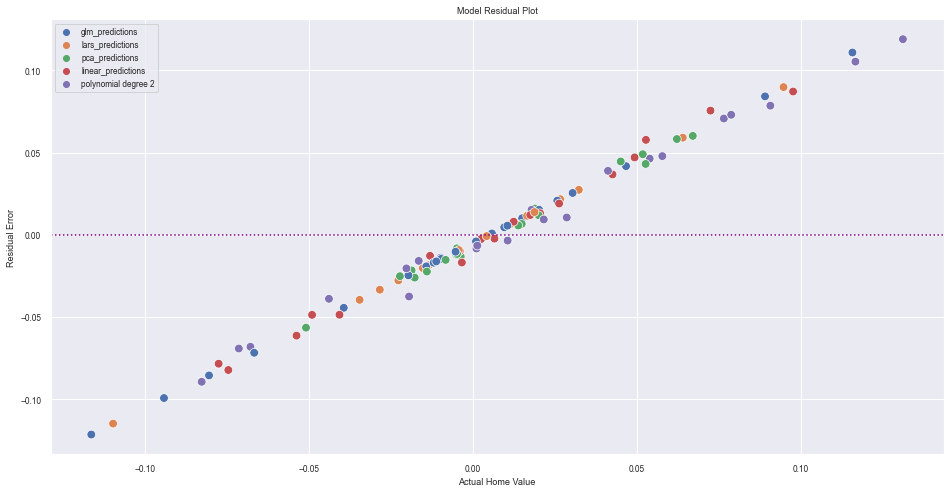

In [70]:
# plotting model residuals
acquire.plot_model_residuals(melt_df)

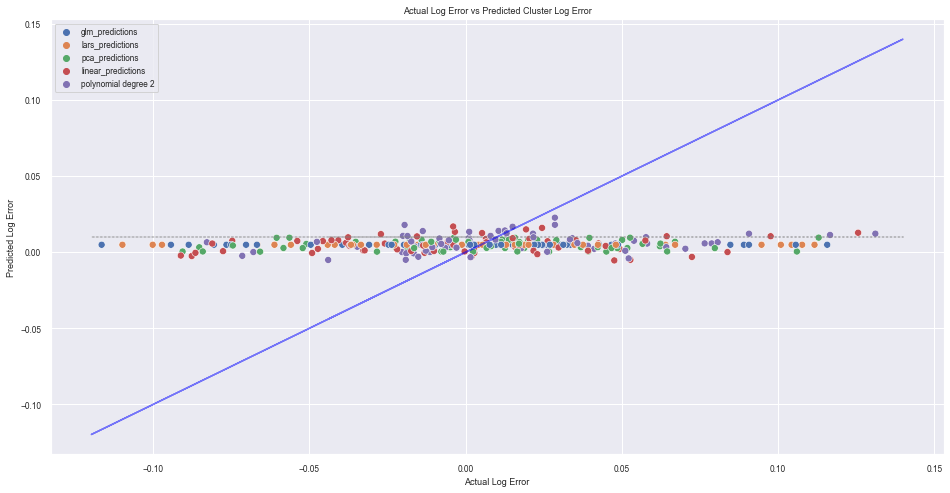

In [71]:
# plotting model predicted home values against target
acquire.plot_models(melt_df)

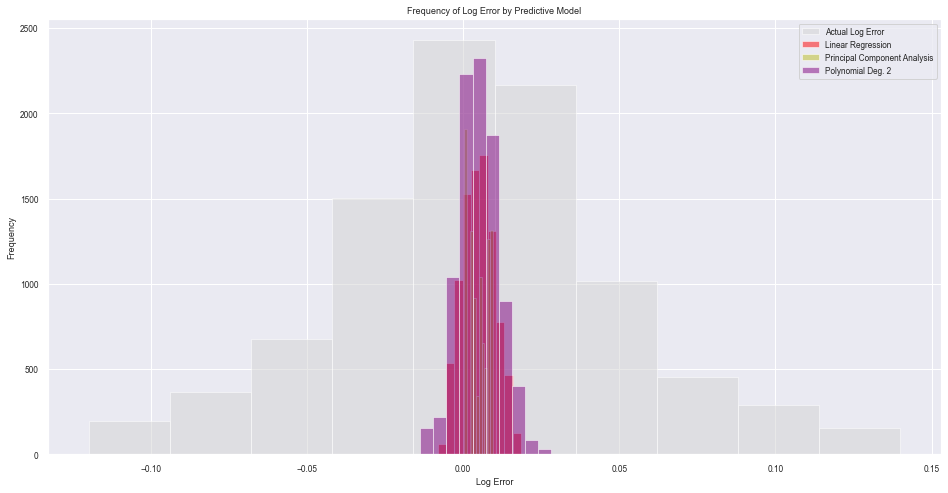

In [72]:
acquire.model_distributions(predictions)

In [73]:
# generating a dataframe
test_df = pd.DataFrame(y_test)

# using poly linear model to transform X_test
X_test_poly = poly.transform(X_test)

# generating model predictions
test_df["model_predictions"] = lm_poly.predict(X_test_poly)
test_df.head()

,logerror,model_predictions
4593,-0.02,0.00
6866,0.02,0.01
44147,0.01,0.02
4679,-0.06,0.01
30076,-0.01,0.00


In [74]:
# returning R-squared score & RMSE on test dataset

rmse_test = sqrt(mean_squared_error(test_df['logerror'], test_df['model_predictions']))

# print('Training R-squared w/Linear Model: {:.3f}'.format(lr_model.score(X_test, y_test)))
print('RMSE for OLS model on the test dataset: {:.2f}'.format(rmse_test))

RMSE for OLS model on the test dataset: 0.05


In [75]:
# returning RMSE report 
# acquire.final_rmse()